In [1]:
import patient as p
import tensorflow as tf
import numpy as np
import myLib
import consts as c



In [2]:
c.WINDOW_SIZE = c.PREPREDICTION_LENGTH + 1000

tabSegments = []
for pStr in c.trainPatients:
    tabSegments = tabSegments + p.patient(pStr).getLabeledSegments()


x_train,y_train = myLib.processDF(tabSegments)

x_test,y_test,x_validation,y_validation = myLib.getTrainValData()




Loading data of patient MSEL_00172


100%|██████████| 248/248 [00:06<00:00, 38.30it/s]


Loading data of patient MSEL_00501


100%|██████████| 277/277 [00:07<00:00, 37.63it/s]


Loading data of patient MSEL_01097


 50%|████▉     | 206/416 [00:05<00:05, 36.35it/s]

Expected 1281.0 got 1205


100%|██████████| 416/416 [00:11<00:00, 36.78it/s]


Loading data of patient MSEL_01575


100%|██████████| 438/438 [00:09<00:00, 44.78it/s] 


Loading data of patient MSEL_01808


 41%|████      | 132/325 [00:03<00:05, 36.98it/s]

Expected 1281.0 got 1217


100%|██████████| 325/325 [00:08<00:00, 38.84it/s]


Loading data of patient MSEL_01838


 39%|███▉      | 158/404 [00:04<00:05, 43.17it/s]

Expected 1281.0 got 1194


100%|██████████| 404/404 [00:10<00:00, 39.88it/s]


In [3]:
print(f"train data: {len(x_train)}\t validation: {len(x_validation)}\t test:{len(x_test)}\n")
unique, counts = np.unique(y_train, return_counts=True)

print(f"TRAIN:     Negatives: {counts[0]} Positives: {counts[1]}")
pos = counts[1]
neg = counts[0]
ratio = round(100 / len(x_train) * pos)
unique, counts = np.unique(y_validation, return_counts=True)
print(f"VALIDATION Negatives: {counts[0]} Positves: {counts[1]}")
unique, counts = np.unique(y_test, return_counts=True)
print(f"TEST       Negatives: {counts[0]} Positves: {counts[1]}")


print(f"\n{ratio} % of positives")




train data: 2139	 validation: 24	 test:84

TRAIN:     Negatives: 2005 Positives: 134
VALIDATION Negatives: 12 Positves: 12
TEST       Negatives: 42 Positves: 42

6 % of positives


In [4]:
METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      #tf.keras.metrics.Precision(name='precision'),
      #tf.keras.metrics.Recall(name='recall'),
      #tf.keras.metrics.AUC(name='auc'),
      #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def getModel2(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(
          16, activation='relu',
          input_shape=(x_train.shape[-1],)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model



In [5]:
model = getModel2()

TrainHistory = model.fit(
    x_train,
    y_train,
    epochs=c.EPOCHS,
    batch_size=c.BATCH_SIZE,
    validation_data=(x_validation, y_validation), 
    verbose=0)

Test accuracy: 0.5


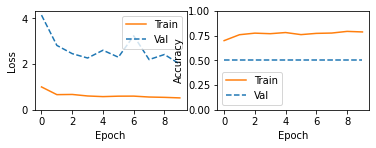

In [6]:
import matplotlib.pyplot as plt


def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color="C1", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color="C0", linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(TrainHistory)
evalutation = model.evaluate(x_test,y_test,verbose=False)
print(f"Test accuracy: {round(evalutation[3],3)}")

In [7]:
myLib.safeRun(model,"Unbalanced",x_train,x_validation,x_test,y_test)